Logistic Regression Best Score: 0.8054
Logistic Regression Test Accuracy: 0.8889
SVM Best Score: 0.8464
SVM Test Accuracy: 0.7778
Decision Tree Best Score: 0.8464
Decision Tree Test Accuracy: 0.8333
KNN Best Score: 0.8179
KNN Test Accuracy: 0.8889
Random Forest Best Score: 0.8464
Random Forest Test Accuracy: 0.8333

Best Model Overall:
Best Model: DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
Best Score: 0.8464


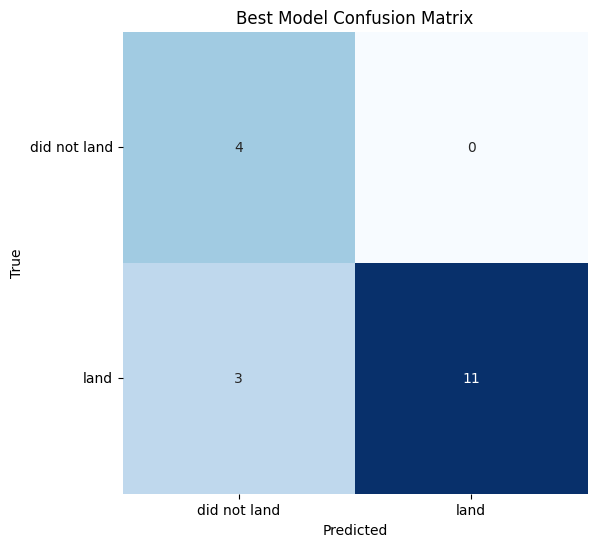

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv("SpaceX_Falcon9.csv")

# Handle missing values
data['PayloadMass'].fillna(data['PayloadMass'].mean(), inplace=True)
data['LandingPad'].fillna('Unknown', inplace=True)

# Feature Engineering
categorical_columns = ["Orbit", "LaunchSite", "LandingPad", "BoosterVersion", "Serial"]
features = data[[
    "FlightNumber", "PayloadMass", "Orbit", "LaunchSite", "Flights", 
    "GridFins", "Reused", "Legs", "LandingPad", "Block", 
    "ReusedCount", "Longitude", "Latitude", "BoosterVersion", "Serial"
]]
features_one_hot = pd.get_dummies(features, columns=categorical_columns, drop_first=True)

# Define features (X) and target (Y)
X = features_one_hot
Y = data["Outcome"].apply(lambda x: 1 if "True" in str(x) else 0).to_numpy()

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define models and hyperparameters
models = {
    "Logistic Regression": GridSearchCV(LogisticRegression(random_state=42),
                                         {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']},
                                         cv=10, scoring='accuracy', n_jobs=-1),
    "SVM": GridSearchCV(SVC(random_state=42),
                          {"C": np.logspace(-3, 3, 5), "gamma": np.logspace(-3, 3, 5), "kernel": ['linear', 'rbf', 'poly', 'sigmoid']},
                          cv=10, scoring='accuracy', n_jobs=-1),
    "Decision Tree": GridSearchCV(DecisionTreeClassifier(random_state=42),
                                   {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [2*n for n in range(1, 10)], 'min_samples_split': [2, 5, 10]},
                                   cv=10, scoring='accuracy', n_jobs=-1),
    "KNN": GridSearchCV(KNeighborsClassifier(),
                          {'n_neighbors': list(range(1, 11)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]},
                          cv=10, scoring='accuracy', n_jobs=-1),
    "Random Forest": GridSearchCV(RandomForestClassifier(random_state=42),
                                   {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
                                   cv=10, scoring='accuracy', n_jobs=-1)
}

# Train models and evaluate
best_model, best_score = None, 0
for model_name, model_cv in models.items():
    model_cv.fit(X_train, Y_train)
    Y_pred = model_cv.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"{model_name} Best Score: {model_cv.best_score_:.4f}")
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    if model_cv.best_score_ > best_score:
        best_score = model_cv.best_score_
        best_model = model_cv.best_estimator_

print("\nBest Model Overall:")
print(f"Best Model: {best_model}")
print(f"Best Score: {best_score:.4f}")

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(ticks=[0.5, 1.5], labels=["did not land", "land"])
    plt.yticks(ticks=[0.5, 1.5], labels=["did not land", "land"], rotation=0)
    plt.show()

Y_pred_best = best_model.predict(X_test)
plot_confusion_matrix(Y_test, Y_pred_best, "Best Model")
pickle.dump(best_model, open("best_model.pkl", "wb"))

